In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
import pickle
import datetime
from IPython.display import HTML, display
import tabulate
from copy import deepcopy
from gene import Gene, GeneChain
from evolution import Evolution
from loader import load_results, load_trading_params, load_nontrading_params, load_indivs
from crosser import Cross10to100, RandomGeneCrosser
from mutator import GausianMutator, MutRandomIndivs, RandomGeneChainMutator
from selector import TopNSelector
from util import plot
from fitness import Fitness
from fitness_test import FitnessTest
from analizer import compare_trading_reports

## Load data

In [6]:
db_indivs = load_indivs()   # pandas object, for fitness function; db individuals have only non-trading parameters
trading_params = load_trading_params()  # pandas object, for precomputation
nontrading_params = load_nontrading_params()    # pandas object, for precomputation

## Init base gene chain

In [7]:
base_gene_chain = GeneChain()
gene_descriptors = []
for index, row in nontrading_params.iterrows():
    dtype = np.dtype(row["TYPE"]).type
    is_interval = True if dtype != bool else False
    min_range = dtype(row["MIN_RANGE"])
    max_value = dtype(max(db_indivs[index]))
    min_value = dtype(min(db_indivs[index]))        
    gene_descriptors.append(str(row["DESCRIPTION"]))
    base_gene_chain.add(Gene(dtype=dtype, is_interval=is_interval, min_radius=min_range/2,
                             min_value=min_value, max_value=max_value, ordering=-1))    

for index, row in trading_params.iterrows():
    is_interval = False
    dtype = np.dtype(row["TYPE"]).type
    min_value = dtype(row["MIN"])
    max_value = dtype(row["MAX"])
    gene_descriptors.append(str(row["DESCRIPTION"]))
    base_gene_chain.add(Gene(dtype=dtype, is_interval=is_interval, tags=["trading"],
                             min_value=min_value, max_value=max_value, ordering=-1))    

## Init genetic algorithm

In [8]:
ev = Evolution(
    MAX_GENS=30,
    fitness=Fitness(),
    base_indiv=base_gene_chain,
    crosser=RandomGeneCrosser(),
    selector=TopNSelector(),    
    multithreaded=True,
    verbose=True)

## Create start population

In [9]:
ev.init_random_indivs(size=10, min_models=5)
ev.dump("population.pkl")
#ev.load_indivs("population.pkl")

Found 10 indivs with 50 tries (42s.)                                                                                                    

## Run 

In [10]:
ev.run(dump="best.pkl")

Generation: 9 | Best fitness: 15.0 | Best ratio: 5.0 | Models: 14 | Time: avg per gen = 28s. total = 258s.                                                                                                    

KeyboardInterrupt: 

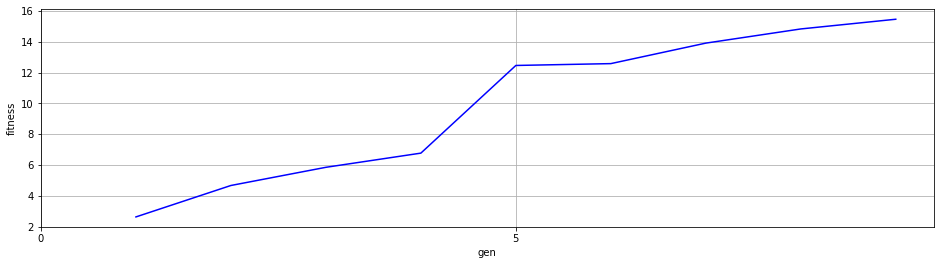

In [11]:
plot([ res["fitness"].fitness for res in ev._run_results ], "fitness")

In [ ]:
ev.print_generation()

## Working with results

In [9]:
fitness = FitnessTest()

In [1]:
with open("indivs/best1.pkl", 'rb') as file:
    indivs = pickle.load(file)
indiv = indivs[0]
indiv.fitness = None
fitness.calc([indiv], ext_info=True)

print(indiv.fitness)
plot(indiv.fitness.fitness_list)

NameError: name 'pickle' is not defined

In [35]:
compare_trading_reports(fitness, indiv.fitness)

unequal trades: 25

#141 real: stops:take:bu = 0:0:1
 emulated: stops:take:bu = 0:0:0, model line 2886
#150 real: stops:take:bu = 0:0:1
 emulated: no trade, no model in db
#157 real: stops:take:bu = 1:0:0
 emulated: stops:take:bu = 1:1:0, model line 3290
#159 real: stops:take:bu = 1:0:0
 emulated: stops:take:bu = 0:0:0, model line 3303
#161 real: stops:take:bu = 0:0:1
 emulated: no trade, no model in db
#172 real: stops:take:bu = 0:0:1
 emulated: stops:take:bu = 0:0:0, model line 3560
#177 real: stops:take:bu = 0:0:0
 emulated: no trade, model line 3642
#207 real: stops:take:bu = 0:0:0
 emulated: no trade, model line 4302
#254 real: stops:take:bu = 1:0:1
 emulated: no trade, model line 5161
#264 real: stops:take:bu = 0:1:0
 emulated: no trade, model line 5402
#281 real: stops:take:bu = 0:0:0
 emulated: no trade, no model in db
#291 real: stops:take:bu = 0:0:0
 emulated: no trade, no model in db
#292 real: stops:take:bu = 1:0:0
 emulated: no trade, no model in db
#366 real: stops:take:b

In [8]:
table = [["#", "Line", "Time", "Type", "Order", "Price", "S/L", "T/P"]]
table.extend(indiv.fitness.trade_history)
display(HTML(tabulate.tabulate(table[:100], tablefmt='html')))

#,Line,Time,Type,Order,Price,S/L,T/P
1,4,2018.01.02 03:40:00,sell limit,1,1.35123,1.35209,1.34968
2,4,2018.01.02 03:58:00,sell,1,1.35123,1.35209,1.34968
3,4,2018.01.02 05:20:00,s/l(buy),1,1.35209,1.35209,1.34968
4,4,2018.01.02 05:20:00,sell limit,2,1.35123,1.35209,1.34968
5,4,2018.01.02 06:05:00,expiration,2,1.35123,1.35209,1.34968
6,11,2018.01.02 07:05:00,buy limit,3,1.35159,1.35105,1.35257
7,11,2018.01.02 07:15:00,buy,3,1.35159,1.35105,1.35257
8,11,2018.01.02 08:01:00,s/l(sell),3,1.35192,1.35192,1.35257
9,19,2018.01.02 16:30:00,buy limit,4,1.35605,1.35497,1.35801
10,19,2018.01.02 16:50:00,delete,4,1.35605,1.35497,1.35801


In [11]:
print_descr = False
count_empty_models = False
print("Indiv parameters:")
for gene_idx, gene in enumerate(indiv):
    if print_descr:
        print(gene_descriptors[gene_idx] + ":\n" + str(gene))
    else:
        print(gene)          
        
print("Inidiv models:")
fit_params = indiv.fitness
trades = 0
table = [["model number", "stops", "take", "bu"]]
for idx in range(len(fit_params.model_indexes)):
    if not count_empty_models and fit_params.stops[idx] == 0 and \
       fit_params.takes[idx] == 0 and fit_params.bus[idx] == 0:
        continue
    trades += fit_params.stops[idx]
    trades += fit_params.takes[idx]
    trades += fit_params.bus[idx]
    table.append([fit_params.model_indexes[idx], fit_params.stops[idx], fit_params.takes[idx], fit_params.bus[idx]])
print("total models number: " + str(len(table)))
print("total trades number: " + str(trades))
#display(HTML(tabulate.tabulate(table, tablefmt='html')))

Indiv parameters:
3, 11
3.5, 29.5
2, 10
0, 4
1.0070585027943646, 1.7303417370609417
0.29267781717635755, 0.7896875952898652
0.207153766253373, 0.9345719650810594
0.17176705333262407, 0.5812044659395345
0.007834128474761781, 0.49747875617145026
-0.9696905230473547
1.411941362001629
1.644612078623053
2.5563196037937206
0.8612886924074048
1.174851030373052
0.6338850931927347
5
45
45
Inidiv models:


AttributeError: 'FitnessResult' object has no attribute 'model_indexes'